# Chatbot with Memory

https://github.com/langchain-ai/langchain-academy/blob/main/module-5/memory_store.ipynb

## LangGraph Store

In [1]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

In [2]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

key = str(uuid.uuid4())

value = {"food_preference": "ピザが好きです"}

in_memory_store.put(namespace_for_memory, key, value)

In [4]:
in_memory_store.list_namespaces()

[('1', 'memories')]

In [5]:
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [7]:
memories

In [9]:
memories[0].dict()

{'value': {'food_preference': 'ピザが好きです'},
 'key': 'dbdb27e7-1dcf-4a29-a588-fd8bb33a33cc',
 'namespace': ['1', 'memories'],
 'created_at': '2024-11-19T01:34:10.387311+00:00',
 'updated_at': '2024-11-19T01:34:10.387316+00:00'}

In [11]:
key

'dbdb27e7-1dcf-4a29-a588-fd8bb33a33cc'

In [13]:
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'value': {'food_preference': 'ピザが好きです'},
 'key': 'dbdb27e7-1dcf-4a29-a588-fd8bb33a33cc',
 'namespace': ['1', 'memories'],
 'created_at': '2024-11-19T01:34:10.387311+00:00',
 'updated_at': '2024-11-19T01:34:10.387316+00:00'}

## 長期記憶を備えたチャットボット

In [14]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [16]:
from IPython.display import display, Image

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

In [17]:
MODEL_SYSTEM_MESSAGE = """あなたは、ユーザーに関する情報を提供する記憶を持つ役立つアシスタントです。
もし、このユーザーに関する記憶がある場合は、それを使用して応答をパーソナライズしてください。
以下がその記憶です（空の場合もあります）：{memory}"""

In [18]:
CREATE_MEMORY_INSTRUCTION = """あなたは、ユーザーに関する情報を収集し、応答をパーソナライズするために使用します。

現在のユーザー情報:
{memory}

指示:
1. 以下のチャット履歴を注意深く確認してください。
2. ユーザーに関する新しい情報を特定してください。例えば:
    - 個人情報（名前、所在地）
    - 好み（好きなもの、嫌いなもの）
    - 興味や趣味
    - 過去の経験
    - 目標や将来の計画
3. 新しい情報を既存の記憶と統合してください。
4. 記憶を分かりやすい箇条書き形式で整理してください。
5. 新しい情報が既存の記憶と矛盾する場合は、最新の情報を保持してください。

注意: ユーザーが直接述べた事実のみを含めてください。推測や推論は行わないでください。

以下のチャット履歴に基づいて、ユーザー情報を更新してください:"""

In [30]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """長期記憶をロードし、パーソナライズされた応答を生成する"""
    user_id = config["configurable"]["user_id"]

    # 長期記憶のロード
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "記憶はありません"
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}

In [31]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """チャット履歴を振り返り、長期記憶に保存する"""
    user_id = config["configurable"]["user_id"]

    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "記憶はありません"
    
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    key = "user_memory"

    store.put(namespace, key, {"memory": new_memory.content})

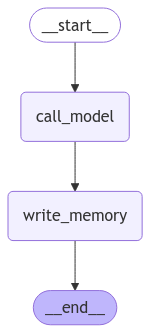

In [32]:
from joblib import Memory


builder = StateGraph(MessagesState)

builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# スレッド（セッション）を超えて記憶する長期記憶
accross_thread_memory = InMemoryStore()

# スレッド内のやり取りを記憶する短期記憶
within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=accross_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [33]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

input_messages = [HumanMessage(content="こんにちは。私の名前は森です。")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

こんにちは。私の名前は森です。
================================== Ai Message ==================================

こんにちは、森さん！お会いできて嬉しいです。今日はどんなことをお話ししましょうか？


In [34]:
input_messages = [HumanMessage(content="私はPCゲームで遊ぶのが好きです。")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

私はPCゲームで遊ぶのが好きです。
================================== Ai Message ==================================

PCゲームが好きなんですね！どんなジャンルのゲームをよくプレイしますか？また、お気に入りのゲームがあれば教えてください。


In [35]:
## 短期記憶の取得
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
state["messages"]

[HumanMessage(content='こんにちは。私の名前は森です。', additional_kwargs={}, response_metadata={}, id='60b15348-5ca2-4187-9adf-3b6d122683bc'),
 AIMessage(content='こんにちは、森さん！お会いできて嬉しいです。今日はどんなことをお話ししましょうか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 94, 'total_tokens': 120, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'stop', 'logprobs': None}, id='run-784fc7e8-f31d-42d6-b75b-9aeffd850f7b-0', usage_metadata={'input_tokens': 94, 'output_tokens': 26, 'total_tokens': 120, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(content='私はPCゲームで遊ぶのが好きです。', additional_kwargs={}, response_metadata={}, id='1d42737e-df

In [36]:
## 長期記憶の取得
user_id = "1"
namespace = ("memory", user_id)
existing_memory = accross_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'memory': '森さんに関する新しい情報を以下のように整理しました：\n\n- 名前: 森さん\n- 好み: PCゲームで遊ぶのが好き\n\nもし他にも教えていただけることがあれば、ぜひお聞かせください！'},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-11-19T02:12:49.714726+00:00',
 'updated_at': '2024-11-19T02:14:02.706334+00:00'}

In [ ]:
# 新しい会話スレッドを開始、ユーザは同じ
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

input_messages = [HumanMessage(content="こんにちは。何をプレイするのがおすすめですか？")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

こんにちは。何をプレイするのがおすすめですか？
================================== Ai Message ==================================

こんにちは、森さん！PCゲームがお好きなんですね。最近のおすすめゲームをいくつか紹介しますね。

1. **バルハラ（Valhalla）** - 美しいビジュアルと感情的なストーリーが魅力のアドベンチャーゲームです。
2. **エルデンリング（Elden Ring）** - オープンワールドのアクションRPGで、探索や戦闘が楽しめます。
3. **スターデューバレー（Stardew Valley）** - 農業や町づくりを楽しむシミュレーションゲームで、リラックスしたい時にぴったりです。
4. **ハロウィン・アドベンチャー（Hollow Knight）** - 美しいアートスタイルと深いストーリーが特徴のメトロイドヴァニアゲームです。

どれか気になるものはありますか？また、他にプレイしたいジャンルがあれば教えてください！


In [39]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

input_messages = [HumanMessage(content="Elden Ringはとても面白かったです！")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Elden Ringはとても面白かったです！
================================== Ai Message ==================================

Elden Ringを楽しんでいただけたんですね！あのゲームは本当に素晴らしい世界観と深いストーリーが魅力ですよね。特に探索やボス戦の緊張感がたまりません。

もしElden Ringのようなゲームを探しているのであれば、以下のタイトルもおすすめです：

1. **ダークソウルシリーズ** - Elden Ringの開発元が手がけた、難易度の高いアクションRPGです。
2. **セキロ：シャドウズダイトゥワイス（Sekiro: Shadows Die Twice）** - スピード感のある戦闘と緻密なストーリーが楽しめるアクションゲームです。
3. **ブラッドボーン（Bloodborne）** - ゴシックホラーの世界観が魅力のアクションRPGで、独特の戦闘スタイルが楽しめます。

これらのゲームも楽しめるかもしれません！他に興味があるジャンルやゲームがあれば教えてくださいね。


In [40]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

input_messages = [HumanMessage(content="全部プレイしたことあります。")]

for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

全部プレイしたことあります。
================================== Ai Message ==================================

すごいですね！ダークソウルシリーズやセキロ、ブラッドボーンもプレイ済みとは、かなりのアクションRPGファンですね。では、もう少しマニアックなタイトルや新しいゲームをいくつか提案しますね。

1. **デモンズソウル（Demon's Souls）** - PS5版のリメイクが出ており、グラフィックが美しくなっています。原点に戻るのも良いかもしれません。
2. **リトルナイトメア2（Little Nightmares II）** - ホラー要素が強いアクションアドベンチャーで、独特の雰囲気が楽しめます。
3. **アーマードコアVI（Armored Core VI: Fires of Rubicon）** - フロムソフトウェアの新作で、メカを操作するアクションゲームです。
4. **ウィッチャー3：ワイルドハント（The Witcher 3: Wild Hunt）** - 深いストーリーと広大なオープンワールドが魅力のRPGです。

これらの中で気になるものはありますか？また、他にプレイしたいゲームのジャンルやテーマがあれば教えてください！


In [41]:
# 長期記憶が更新されているかチェック
user_id = "1"
namespace = ("memory", user_id)
existing_memory = accross_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'value': {'memory': '現在のユーザー情報を更新しました：\n\n- 名前: 森さん\n- 好み: PCゲームで遊ぶのが好き\n- 最近の興味: ゲームのおすすめを探している\n- 最近プレイしたゲーム: Elden Ringがとても面白かった\n- プレイ済みのゲーム: Elden Ring、ダークソウルシリーズ、セキロ：シャドウズダイトゥワイス、ブラッドボーン\n\nもし他にも教えていただけることがあれば、ぜひお聞かせください！'},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-11-19T02:12:49.714726+00:00',
 'updated_at': '2024-11-19T02:21:31.966248+00:00'}

In [43]:
print(existing_memory.dict()["value"]["memory"])

現在のユーザー情報を更新しました：

- 名前: 森さん
- 好み: PCゲームで遊ぶのが好き
- 最近の興味: ゲームのおすすめを探している
- 最近プレイしたゲーム: Elden Ringがとても面白かった
- プレイ済みのゲーム: Elden Ring、ダークソウルシリーズ、セキロ：シャドウズダイトゥワイス、ブラッドボーン

もし他にも教えていただけることがあれば、ぜひお聞かせください！
